In [1]:
!pip install agglomcluster nltk datasketch networkx

In [2]:
from pprint import pprint as pp

def read(fname):
    with open(fname, 'rb') as fhandle:
        return fhandle.read().decode('UTF-8')
    
def progress(iterable, print_index=100, size=None):
    if size is None:
        size = len(iterable)
    for i, e in enumerate(iterable):
        if i % print_index == 0 and i > 0:
            print "Progress: {} / {}".format(i, size)
        yield e

# Download from http://govrank.org/archive and convert with pdftotext
texts = { source: read(source) for source in [
    'budgets/sunnyvale_2015.txt',
    'budgets/sausilito_2016.txt',
    'budgets/oakland_2015.txt',
    'budgets/mountain_view_2015.txt',
    'budgets/addison_tx_2015.txt',
    'budgets/cleveland_oh_2015.txt',
    'budgets/fort_lauderdale_fl_2014.txt',
    'budgets/lakewood_co_2015.txt',
    'budgets/wyandotte_count_kansas_city_2013.txt']}

In [3]:
import nltk

# Organize our NLTK tools here
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.RegexpTokenizer('\s+', gaps=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
porter = nltk.stem.porter.PorterStemmer()

extract_words = tokenizer.tokenize
extract_sentences = sent_detector.tokenize

In [4]:
import re
from collections import namedtuple

# Let's track attributes related to the raw sentences
Sentence = namedtuple('Sentence', ['original', 'tokens', 'source'])

def tokenize_sentence(sent):
    # Get the set of stemmed, non-stop words
    return set(
        porter.stem(w.lower()) for w in extract_words(sent)
        if w.lower() not in stop_words and
        re.match("^[a-zA-Z]+$", w) and
        len(porter.stem(w.lower())) > 2)

sentences = []
for source, text in texts.iteritems():
    original_sent_list = extract_sentences(text)
    sent_tokenize_list = map(tokenize_sentence, original_sent_list)
    source_sentences = map(lambda (a,b): Sentence(a,b,source), zip(original_sent_list, sent_tokenize_list))
    sentences.extend(filter(lambda s: len(s.tokens) > 3, source_sentences))

In [5]:
def jaccard(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    try:
        return float(len(s1 & s2)) / len(s1 | s2)
    except ZeroDivisionError:
        return 0.0

# This is just to filter out weak relationships and speed up clustering
# Lower is better, but too low adds a bunch of meaningless work
THRESHOLD = 0.4

In [6]:
# This would be n^2 work... we can do better

# print '{} total sentences'.format(len(sentences))

# graph = nx.Graph()
# edges = []
# for index_one, sent_one in progress(enumerate(sentences), 20, len(sentences)):
#     if index_one and (index_one % 100) == 0:
#         print index_one
#     for index_two, sent_two in enumerate(sentences):
#         if index_one == index_two:
#             continue
#         score = jaccard(sent_one.tokens, sent_two.tokens)
#         if score > THRESHOLD:
#             edges.append((index_one, index_two, { 'weight': score }))
# graph.add_edges_from(edges)

# print '{} sentences -> {} edges'.format(len(graph), graph.size())

In [7]:
from datasketch import MinHash, MinHashLSH

# This estimates the relationships we would make by n^2 comparisons
# See https://en.wikipedia.org/wiki/MinHash for how it works
def min_hash(s):
    h = MinHash(num_perm=128)
    for w in s:
        h.update(w.encode('utf8'))
    return h

# To distribute this you'll need some custom tooling here
lsh = MinHashLSH(threshold=THRESHOLD, num_perm=128)
for index, sent in progress(enumerate(sentences), 1500, len(sentences)):
    lsh.insert(index, min_hash(sent.tokens))

Progress: 1500 / 26109
Progress: 3000 / 26109
Progress: 4500 / 26109
Progress: 6000 / 26109
Progress: 7500 / 26109
Progress: 9000 / 26109
Progress: 10500 / 26109
Progress: 12000 / 26109
Progress: 13500 / 26109
Progress: 15000 / 26109
Progress: 16500 / 26109
Progress: 18000 / 26109
Progress: 19500 / 26109
Progress: 21000 / 26109
Progress: 22500 / 26109
Progress: 24000 / 26109
Progress: 25500 / 26109


In [8]:
import networkx as nx

print '{} total sentences'.format(len(sentences))

graph = nx.Graph()
edges = []
for index_one, sent in progress(enumerate(sentences), 1000, len(sentences)):
    for index_two in lsh.query(min_hash(sent.tokens)):
        if index_two == index_one:
            continue
        # Double check if our score matches the minhash estimate (which it wont many times)
        score = jaccard(sent.tokens, sentences[index_two].tokens)
        if score > THRESHOLD:
            edges.append((index_one, index_two, { 'weight': score }))
graph.add_edges_from(edges)

print '{} sentences -> {} edges'.format(len(graph), graph.size())

26109 total sentences
Progress: 1000 / 26109
Progress: 2000 / 26109
Progress: 3000 / 26109
Progress: 4000 / 26109
Progress: 5000 / 26109
Progress: 6000 / 26109
Progress: 7000 / 26109
Progress: 8000 / 26109
Progress: 9000 / 26109
Progress: 10000 / 26109
Progress: 11000 / 26109
Progress: 12000 / 26109
Progress: 13000 / 26109
Progress: 14000 / 26109
Progress: 15000 / 26109
Progress: 16000 / 26109
Progress: 17000 / 26109
Progress: 18000 / 26109
Progress: 19000 / 26109
Progress: 20000 / 26109
Progress: 21000 / 26109
Progress: 22000 / 26109
Progress: 23000 / 26109
Progress: 24000 / 26109
Progress: 25000 / 26109
Progress: 26000 / 26109
6943 sentences -> 36361 edges


In [9]:
import time
from hac import GreedyAgglomerativeClusterer

start = time.time()
dendro = GreedyAgglomerativeClusterer().cluster(graph)
print 'Clustering {} clusters took {} seconds'.format(len(dendro.clusters()), time.time() - start)

Clustering 782 clusters took 12.1087648869 seconds


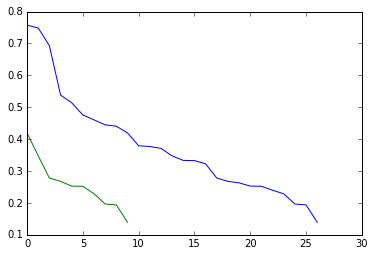

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def centroid(cluster):
    max_score = 0.0
    max_elem = None
    for c1 in cluster:
        score = 0.0
        for c2 in cluster:
            score += jaccard(c1.tokens, c2.tokens)
        if score > max_score:
            max_score = score
            max_elem = c1
    return max_elem

def similarity(cluster):
    score = 0.0
    for c1 in cluster:
        for c2 in cluster:
            score += jaccard(c1.tokens, c2.tokens)
    return score / (len(cluster) ** 2)

# Plot the cluster consitency
# 1.0 means all the phrases are identical, not so interesting
# low values mean the cluster has a wide spread of components
# which all connect piece-meal
clusters = [[sentences[i] for i in c] for c in dendro.clusters()]
focused_clusters = sorted(
    filter(lambda c: len(c) > 5 and len(c) < 50, clusters), key=similarity, reverse=True)
plt.plot(map(similarity, focused_clusters))
interesting_clusters = [c for c in focused_clusters if len(set(s.source for s in c)) > 1]
# Our cross-source clusters have lower similarity but avoid repeated phrasing issues
plt.plot(map(similarity, interesting_clusters))

782
29
18
10
9
2
0
Multi-source focused clusters: 10


(array([ 513.,  184.,    0.,   35.,   11.,    0.,   10.,    0.,    3.,
           3.,    0.,    3.,    0.,    2.,    0.,    0.,    1.,    0.,
           2.,    3.,    0.,    1.,    1.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    1.,    0.,    1.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  1.  ,   1.61,   2.22,   2.83,   3.44,   4.05,   4.66,   5.27,
          5.88,   6.49,   7.1 ,   7.71,   8.32,   8.93,   9.54,  10.15,
         10.76,  11.37,  11.98,  12.59,  13.2 ,  13.81,  14.42,  1

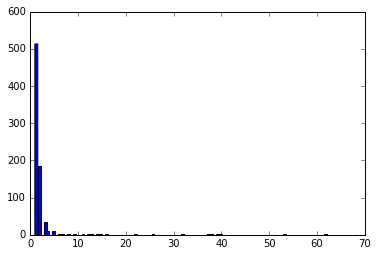

In [11]:
# See how our cluster sizes are distributed
# Ideally a nice laplacian distribution should be visible

print len(clusters)
print len(filter(lambda c: len(c) > 5, clusters))
print len(filter(lambda c: len(c) > 10, clusters))
print len(filter(lambda c: len(c) > 15, clusters))
print len(filter(lambda c: len(c) > 20, clusters))
print len(filter(lambda c: len(c) > 50, clusters))
print len(filter(lambda c: len(c) > 100, clusters))

print 'Multi-source focused clusters: {}'.format(sum(1 for c in interesting_clusters))

# Ours is a little weak, we don't get many medium size clusters
# This indicates we could use more data or form more/better edges
plt.hist(map(len, clusters), 100)

In [12]:
pp(map(centroid, interesting_clusters))

[Sentence(original=u'[New in FY 2012/13]\n\nN/A\n\nN/A\n\n156,306\n\nN/A\n\n96\n99%\n\n49\n94%\n\nPercent of total Department operating budget expended.', tokens=set([u'oper', u'depart', u'total', u'percent', u'budget']), source='budgets/sunnyvale_2015.txt'),
 Sentence(original=u'P a g e 108 | 181\n\nINVESTING IN THE QUALITY OF SAUSALITO\u2019S FUTURE\n\n\x0cCITY OF SAUSALITO\n\nSTRATEGIC RESOURCE ALLOCATION PLAN \u2013 TWO YEAR BUDGET\n\nFY 2014 \u2013 2016\n\nDEPARTMENT REVENUES AND EXPENSES BY CATEGORY\nDescription\nPermits & Fees\nInterest Income\nTotal Revenues\nTransfers\nTotal Expenditures\n\nActual 2012-13\n171,127\n1,106\n172,234\n\nAdopted 2013-14\n150,000\n150,000\n\nAmended 2013-14\n150,000\n150,000\n\nProposed 2014-15\n150,000\n150,000\n\nProjected 2015-16\n150,000\n150,000\n\n126,042\n126,042\n\n180,750\n180,750\n\n464,340\n464,340\n\n241,400\n241,400\n\n150,000\n150,000\n\nP a g e 109 | 181\n\nINVESTING IN THE QUALITY OF SAUSALITO\u2019S FUTURE\n\n\x0cCITY OF SAUSALITO\n

In [13]:
check = interesting_clusters[0]

# Total operating budgets for departments are a common topic
pp(centroid(check))
print
pp(check)

Sentence(original=u'[New in FY 2012/13]\n\nN/A\n\nN/A\n\n156,306\n\nN/A\n\n96\n99%\n\n49\n94%\n\nPercent of total Department operating budget expended.', tokens=set([u'oper', u'depart', u'total', u'percent', u'budget']), source='budgets/sunnyvale_2015.txt')

[Sentence(original=u'T\n\no w n\n\nO\n\nf\n\nA\n\nd d i s o n\n\n,\n\nBudgeted operating revenues total\n$10,588,726, an increase of $323,187\nfrom the previous year.', tokens=set([u'oper', u'previou', u'budget', u'revenu', u'increas', u'total']), source='budgets/addison_tx_2015.txt'),
 Sentence(original=u'Total operating expenses are budgeted at\n$847,992 for FY2015.', tokens=set([u'oper', u'total', u'expens', u'budget']), source='budgets/addison_tx_2015.txt'),
 Sentence(original=u'Department Budgets\u2014includes operating plans for all City departments;\n\n5.', tokens=set([u'oper', u'citi', u'depart', u'plan']), source='budgets/mountain_view_2015.txt'),
 Sentence(original=u'[New in FY 2012/13]\n\nN/A\n\nN/A\n\n156,306\n\nN/A\n\n

In [14]:
check = interesting_clusters[4]

# Project funds reserved for specific purposes are common
pp(centroid(check))
print
pp(check)

Sentence(original=u'* Accounts for use of fund balance for balancing purposes.', tokens=set([u'fund', u'account', u'use', u'balanc']), source='budgets/oakland_2015.txt')

[Sentence(original=u'Funds budgeted in FY 2019/20 and FY 2020/21 are for design and\nconstruction of all greens and sand bunkers at both courses, including the practice putting greens.', tokens=set([u'practic', u'budget', u'construct', u'fund', u'sand', u'green', u'includ', u'bunker', u'put', u'design']), source='budgets/sunnyvale_2015.txt'),
 Sentence(original=u'The Property/Casualty City Insurance Fund has adopted expenditures of $21.5 million for\nFY 2014.', tokens=set([u'million', u'insur', u'fund', u'adopt', u'citi', u'expenditur']), source='budgets/fort_lauderdale_fl_2014.txt'),
 Sentence(original=u'The FY 2015/16 and FY 2016/17 budgets fund the design of the project\nand the FY 2016/17 budget includes construction costs.', tokens=set([u'budget', u'construct', u'project', u'fund', u'design', u'includ']), source=

In [15]:
check = focused_clusters[1]

# Our sentence parser failed us here -- we've got a jumble of terms not getting separated
pp(centroid(check))
print
pp(check)

Sentence(original=u'2011\nACTUAL\nBeginning Fund Balance\n\n2012\nACTUAL\n\n2013\nBUDGET\n\n2013\nAMENDED\n\n2014\nBUDGET\n\n$341,879\n\n$248,505\n\n$213,771\n\n$302,416\n\nREVENUE\nTax Revenue\nPermits and Licenses\nIntergovernmental Revenues\nCharges for Services\nFines, Forfeits, Fees\nInterest Income\nMiscellaneous Revenues\nReimbursements\nOther Financing Sources\nTotal Revenues\n\n1,005,544\n0\n0\n0\n0\n5,426\n0\n0\n0\n$1,010,970\n\n986,589\n0\n0\n0\n0\n2,044\n124,736\n0\n0\n$1,113,369\n\n949,224\n0\n0\n0\n0\n5,000\n0\n0\n0\n$954,224\n\n966,290\n947,153\n0\n0\n0\n0\n0\n0\n0\n0\n1,500\n1,200\n0\n0\n0\n164,700\n0\n0\n$967,790 $1,113,053\n\nEXPENSES\nPersonnel\nServices\nSupplies\nGrants, Claims\nTransfers, Other\nCapital Outlay\nDebt Service\nReserves\nTotal Expenses\n\n0\n0\n0\n0\n0\n1,054,193\n50,151\n0\n$1,104,344\n\n0\n0\n0\n0\n0\n0\n0\n0\n0\n0\n867,700\n955,105\n191,758\n140,200\n0\n25,000\n$1,059,458 $1,120,305\n\n0\n0\n0\n0\n0\n0\n0\n0\n0\n0\n652,705\n528,607\n140,200\n962,0